In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define GAT model for batched data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True, edge_dim=1)
        self.pool = global_mean_pool  # Can also use global_max_pool or global_add_pool
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.BatchNorm1d(out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        out, attn_weights = self.gat(x, edge_index, edge_attr, return_attention_weights=True)
        out = self.dropout(out)
        out = self.pool(out, batch)  # Pool over nodes in each graph
        out = self.norm(out)
        out = self.dropout(out) 
        out = self.linear(out)
        return out, attn_weights

def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

In [2]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy


def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy, _


In [3]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [4]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
import torch
import torch.nn.functional as F

def weighted_positive_loss(y_pred, y_true, lambda_weight=0.01):
    # BCE Loss
    bce_loss = F.binary_cross_entropy(y_pred, y_true)

    # Additional Weighted Positive Term
    positive_mask = (y_true == 1.0).float()
    P = positive_mask.sum()

    if P > 0:
        wp_term = torch.sqrt(
            torch.mean((torch.log(y_pred[positive_mask.bool()] + 1) - torch.log(y_true[positive_mask.bool()] + 1)) ** 2)
        )
    else:
        wp_term = torch.tensor(0.0, device=y_pred.device)

    total_loss = bce_loss + lambda_weight * wp_term
    return total_loss


Training on bin 41/50
Bin 41, Epoch 1/2000, Train Loss: 0.7290, Validation Loss: 0.7394,  ValAccuracy: 0.2175, LR: 0.000250
Bin 41, Epoch 501/2000, Train Loss: 0.4254, Validation Loss: 0.3454,  ValAccuracy: 0.8814, LR: 0.000215
Bin 41, Epoch 1001/2000, Train Loss: 0.3984, Validation Loss: 0.2709,  ValAccuracy: 0.9266, LR: 0.000130
Bin 41, Epoch 1501/2000, Train Loss: 0.3952, Validation Loss: 0.2757,  ValAccuracy: 0.9153, LR: 0.000045


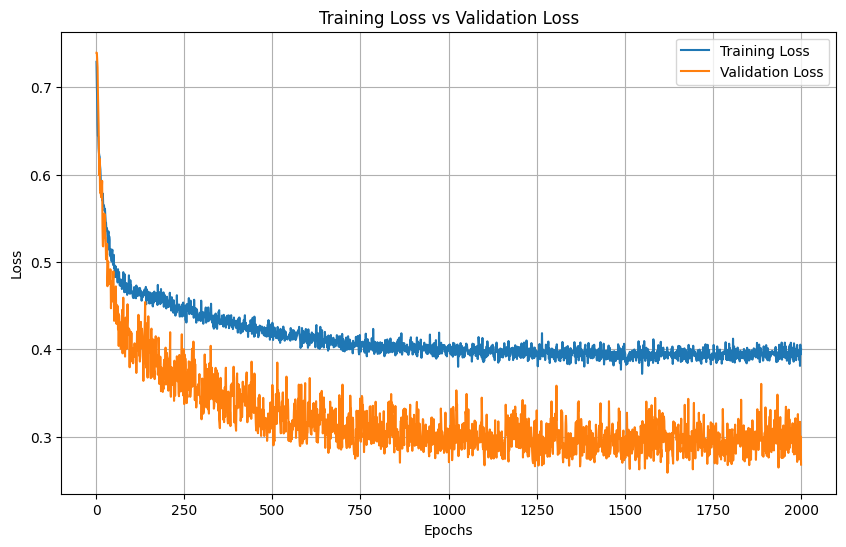

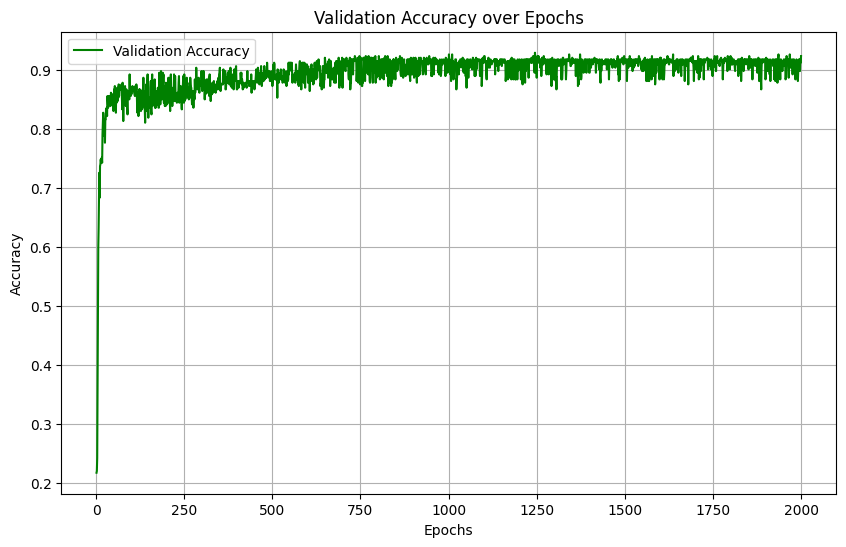

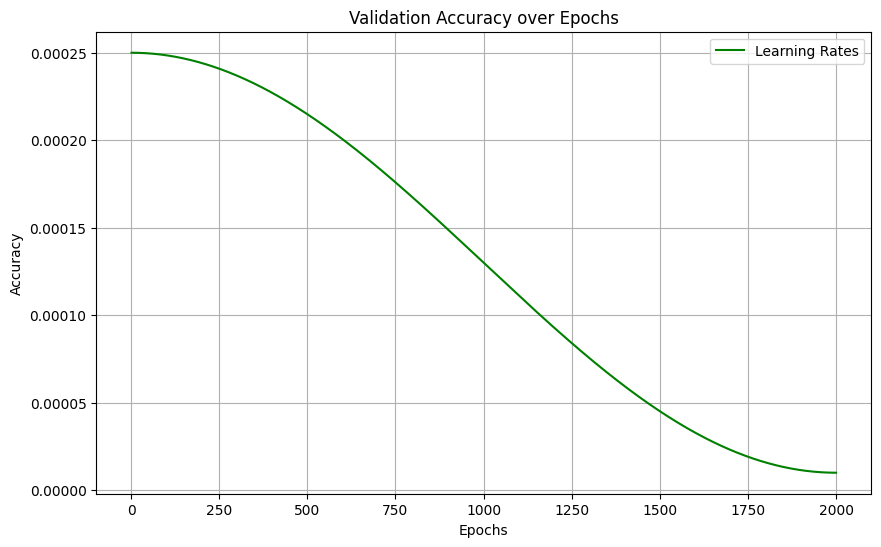

Model for bin 41 saved to GATModels-5A_exp2v2/Models/model_bin_41.pth
Attention weights for bin 41 saved to GATModels-5A_exp2v2/Weights/attn_bin_41.pt
Training on bin 42/50
Bin 42, Epoch 1/2000, Train Loss: 0.7300, Validation Loss: 0.6662,  ValAccuracy: 0.7797, LR: 0.000250
Bin 42, Epoch 501/2000, Train Loss: 0.3890, Validation Loss: 0.3514,  ValAccuracy: 0.8870, LR: 0.000215
Bin 42, Epoch 1001/2000, Train Loss: 0.3607, Validation Loss: 0.3537,  ValAccuracy: 0.9011, LR: 0.000130
Bin 42, Epoch 1501/2000, Train Loss: 0.3655, Validation Loss: 0.3939,  ValAccuracy: 0.8983, LR: 0.000045


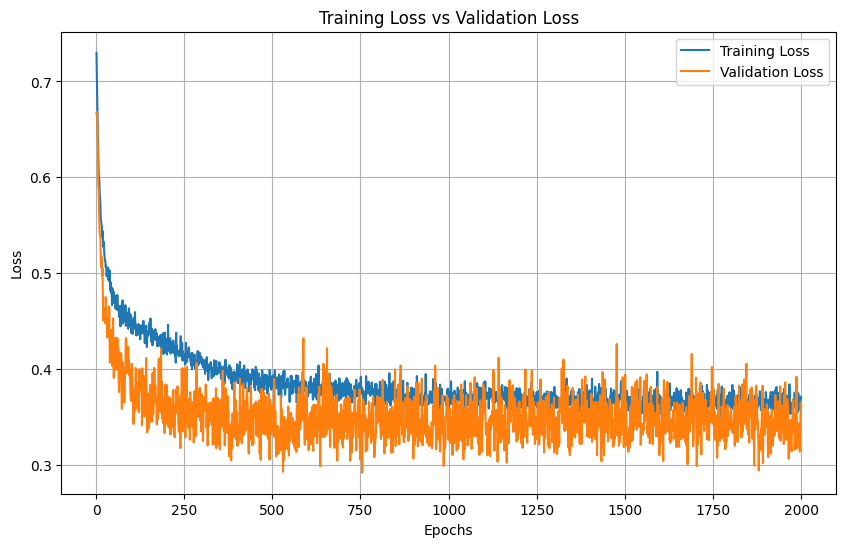

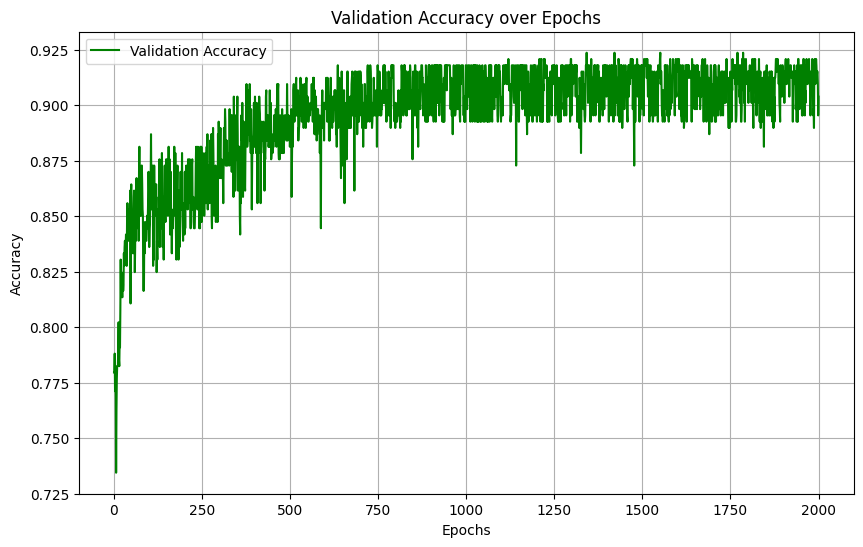

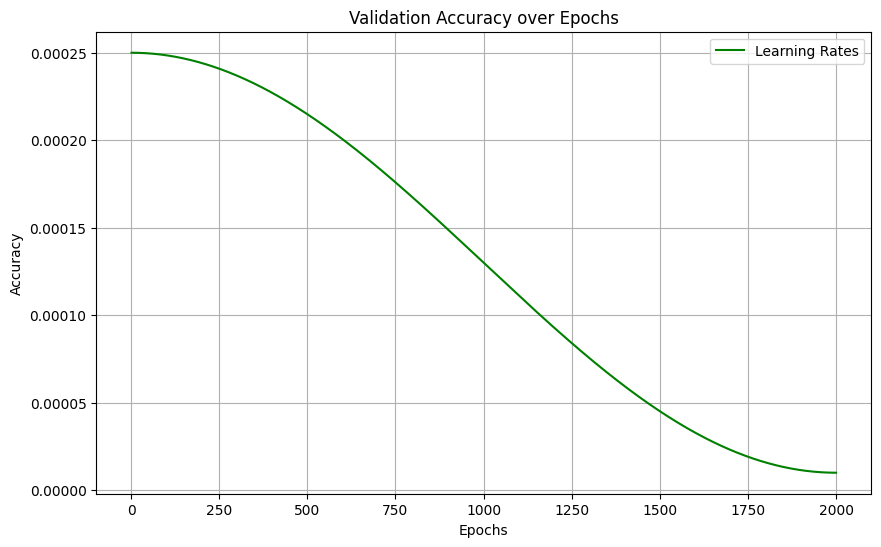

Model for bin 42 saved to GATModels-5A_exp2v2/Models/model_bin_42.pth
Attention weights for bin 42 saved to GATModels-5A_exp2v2/Weights/attn_bin_42.pt
Training on bin 43/50
Bin 43, Epoch 1/2000, Train Loss: 0.9144, Validation Loss: 0.7197,  ValAccuracy: 0.2062, LR: 0.000250
Bin 43, Epoch 501/2000, Train Loss: 0.3806, Validation Loss: 0.3290,  ValAccuracy: 0.9068, LR: 0.000215
Bin 43, Epoch 1001/2000, Train Loss: 0.3742, Validation Loss: 0.3493,  ValAccuracy: 0.9096, LR: 0.000130
Bin 43, Epoch 1501/2000, Train Loss: 0.3798, Validation Loss: 0.3636,  ValAccuracy: 0.9068, LR: 0.000045


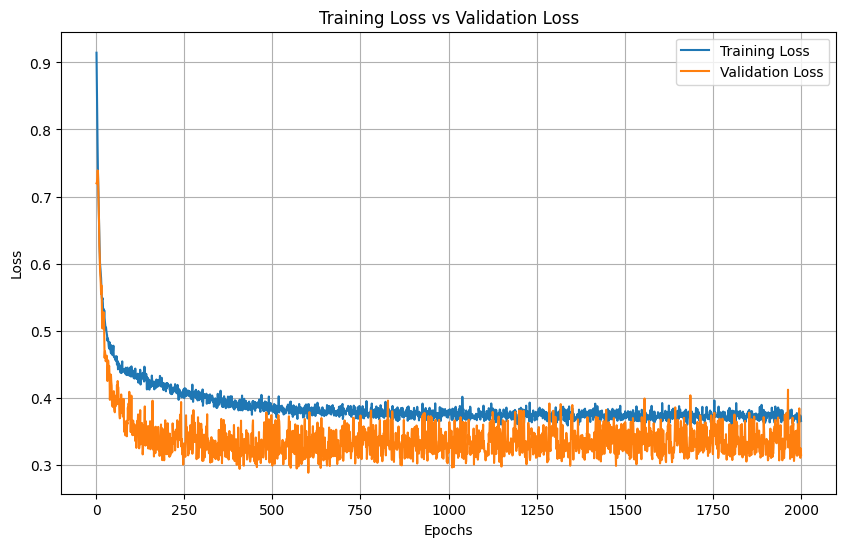

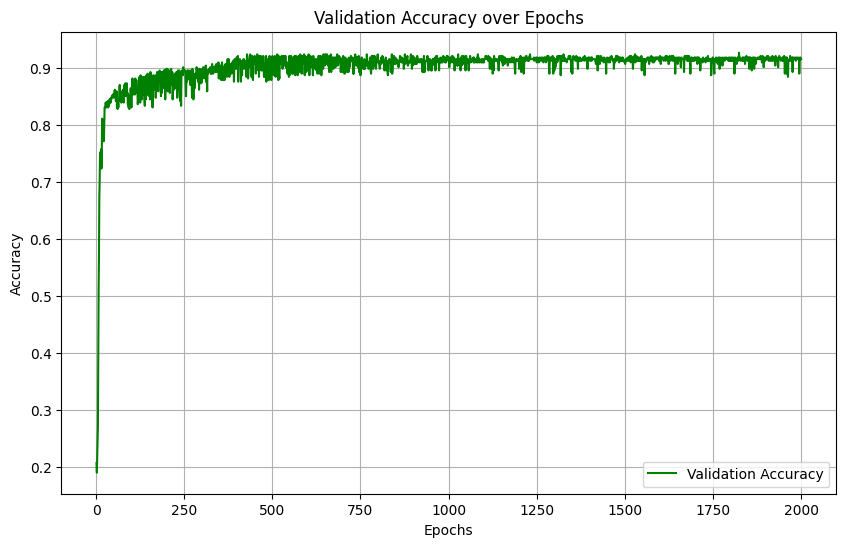

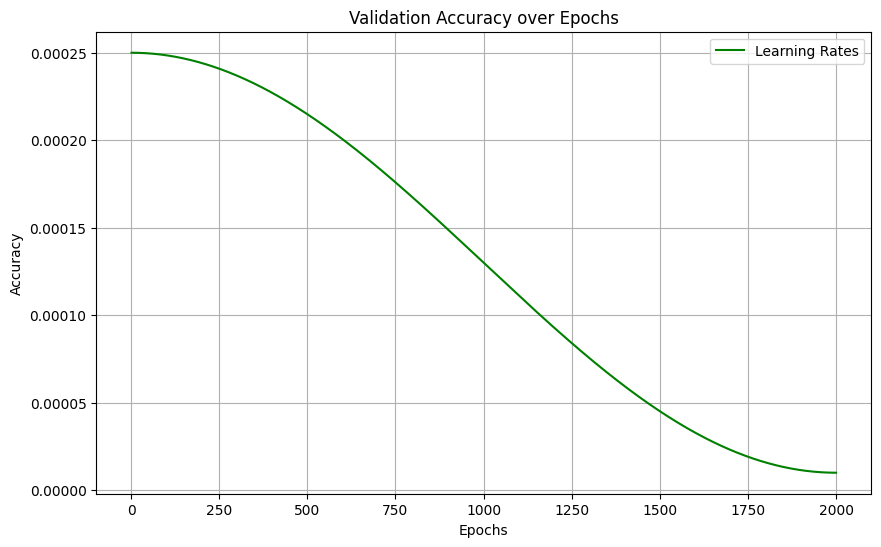

Model for bin 43 saved to GATModels-5A_exp2v2/Models/model_bin_43.pth
Attention weights for bin 43 saved to GATModels-5A_exp2v2/Weights/attn_bin_43.pt
Training on bin 44/50
Bin 44, Epoch 1/2000, Train Loss: 0.7689, Validation Loss: 0.6995,  ValAccuracy: 0.2655, LR: 0.000250
Bin 44, Epoch 501/2000, Train Loss: 0.3747, Validation Loss: 0.3669,  ValAccuracy: 0.9124, LR: 0.000215
Bin 44, Epoch 1001/2000, Train Loss: 0.3407, Validation Loss: 0.3587,  ValAccuracy: 0.9096, LR: 0.000130
Bin 44, Epoch 1501/2000, Train Loss: 0.3404, Validation Loss: 0.3269,  ValAccuracy: 0.9124, LR: 0.000045


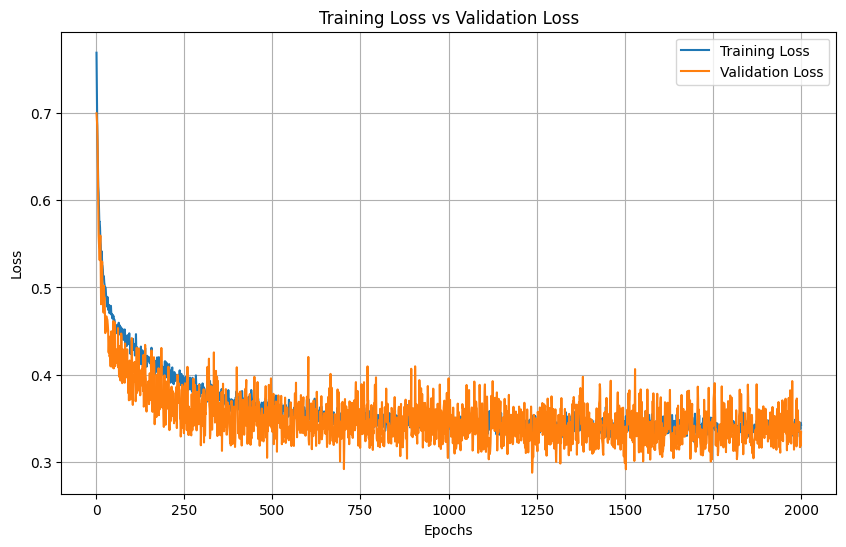

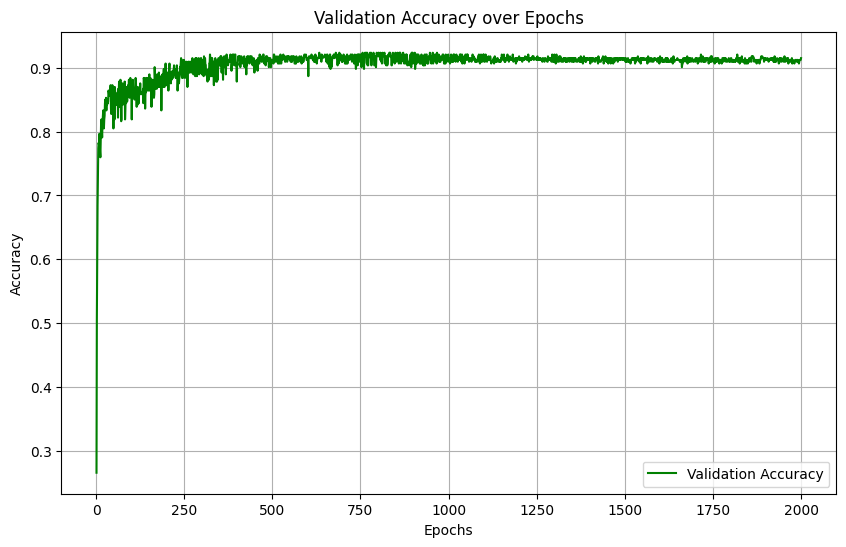

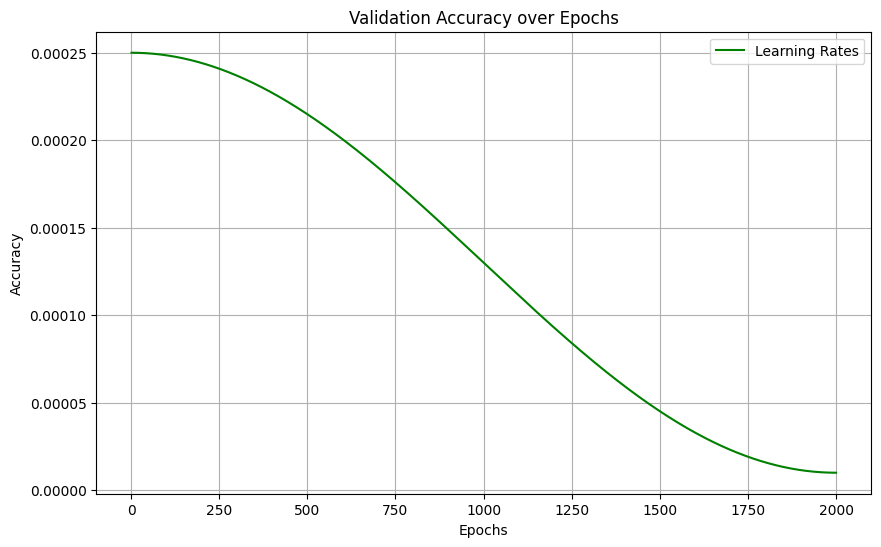

Model for bin 44 saved to GATModels-5A_exp2v2/Models/model_bin_44.pth
Attention weights for bin 44 saved to GATModels-5A_exp2v2/Weights/attn_bin_44.pt
Training on bin 45/50
Bin 45, Epoch 1/2000, Train Loss: 0.8811, Validation Loss: 0.7082,  ValAccuracy: 0.1921, LR: 0.000250
Bin 45, Epoch 501/2000, Train Loss: 0.4043, Validation Loss: 0.3513,  ValAccuracy: 0.8842, LR: 0.000215
Bin 45, Epoch 1001/2000, Train Loss: 0.3636, Validation Loss: 0.3991,  ValAccuracy: 0.9011, LR: 0.000130
Bin 45, Epoch 1501/2000, Train Loss: 0.3727, Validation Loss: 0.4308,  ValAccuracy: 0.8927, LR: 0.000045


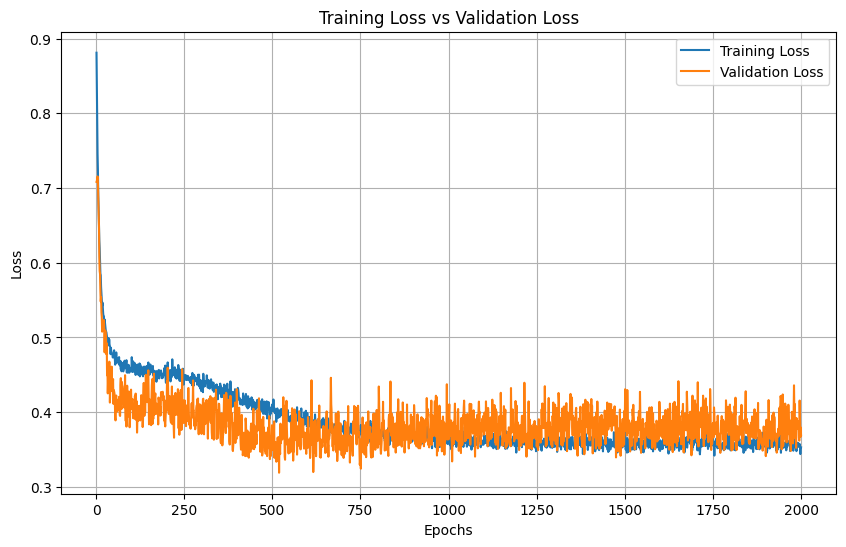

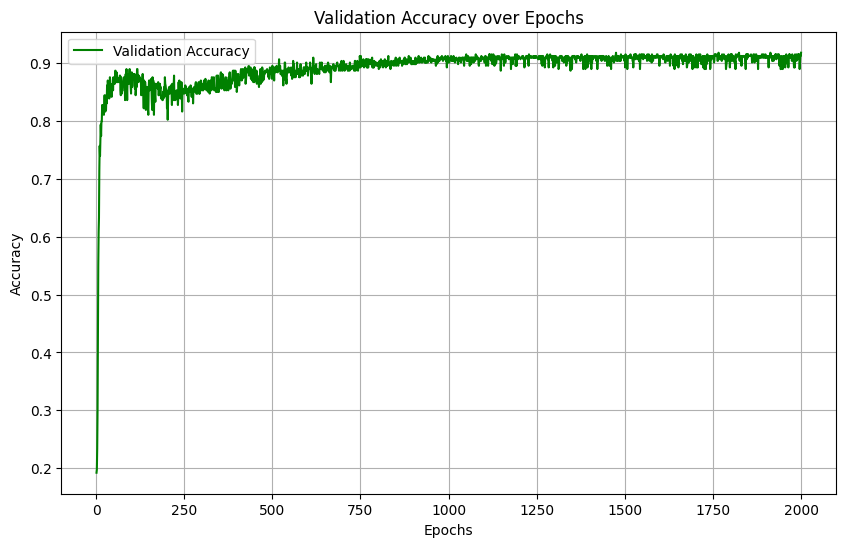

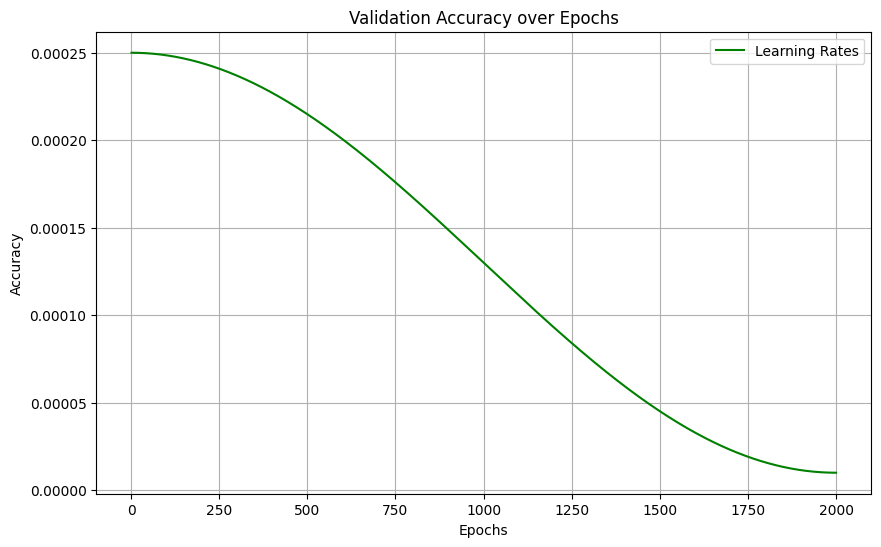

Model for bin 45 saved to GATModels-5A_exp2v2/Models/model_bin_45.pth
Attention weights for bin 45 saved to GATModels-5A_exp2v2/Weights/attn_bin_45.pt
Training on bin 46/50
Bin 46, Epoch 1/2000, Train Loss: 0.7043, Validation Loss: 0.6985,  ValAccuracy: 0.2401, LR: 0.000250
Bin 46, Epoch 501/2000, Train Loss: 0.4486, Validation Loss: 0.3978,  ValAccuracy: 0.8362, LR: 0.000215
Bin 46, Epoch 1001/2000, Train Loss: 0.3777, Validation Loss: 0.3156,  ValAccuracy: 0.9011, LR: 0.000130
Bin 46, Epoch 1501/2000, Train Loss: 0.3661, Validation Loss: 0.2682,  ValAccuracy: 0.9096, LR: 0.000045


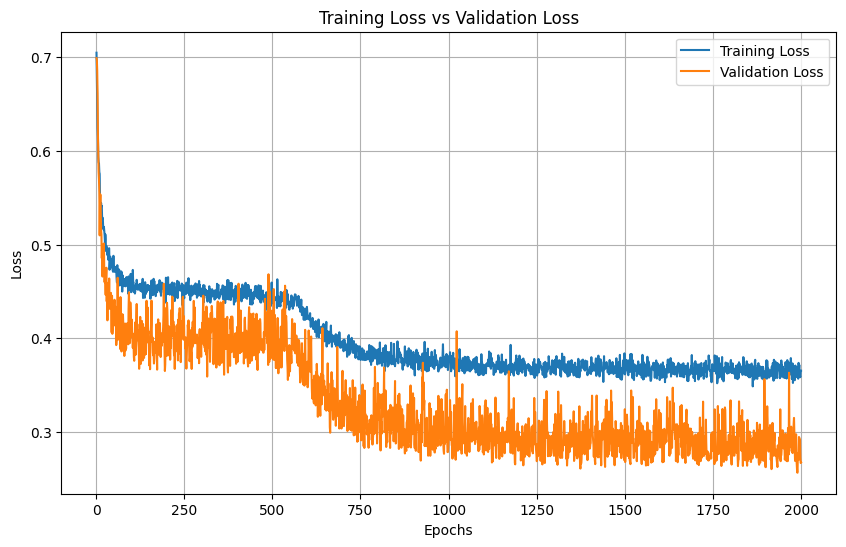

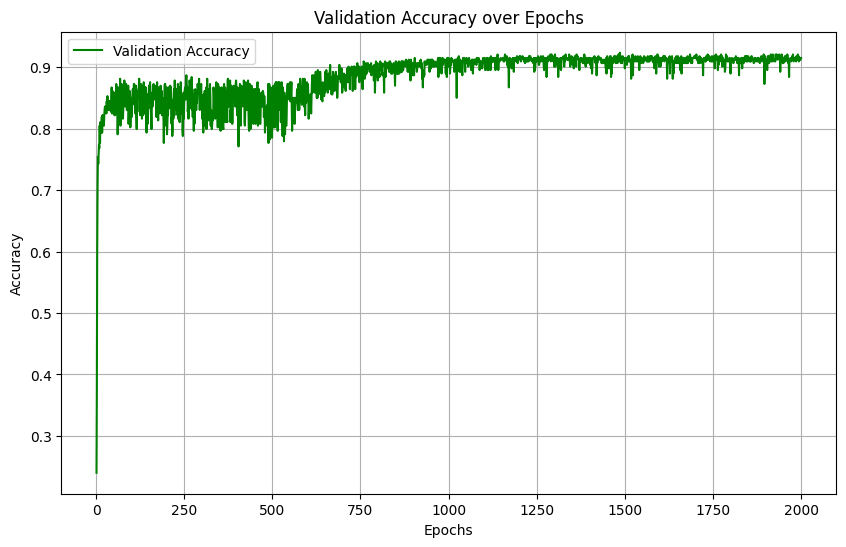

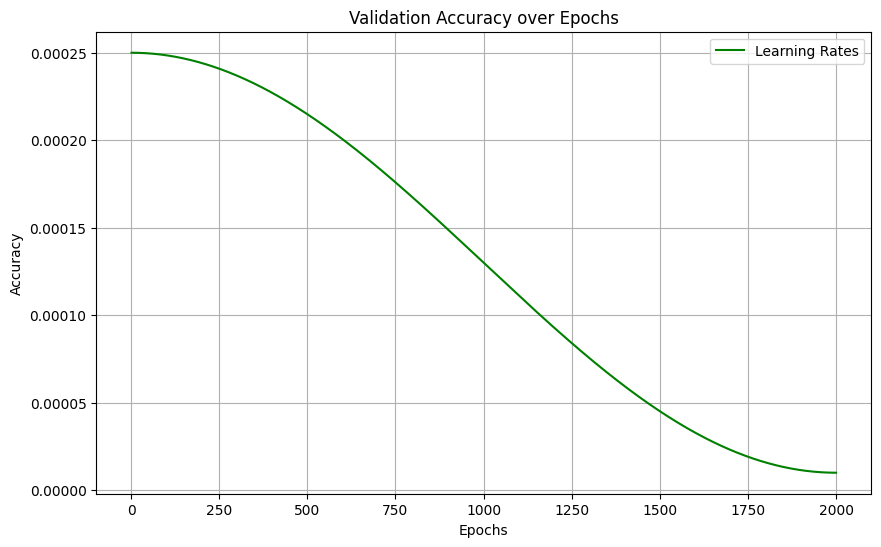

Model for bin 46 saved to GATModels-5A_exp2v2/Models/model_bin_46.pth
Attention weights for bin 46 saved to GATModels-5A_exp2v2/Weights/attn_bin_46.pt
Training on bin 47/50
Bin 47, Epoch 1/2000, Train Loss: 0.6810, Validation Loss: 0.7094,  ValAccuracy: 0.2175, LR: 0.000250
Bin 47, Epoch 501/2000, Train Loss: 0.3485, Validation Loss: 0.2285,  ValAccuracy: 0.9266, LR: 0.000215
Bin 47, Epoch 1001/2000, Train Loss: 0.3453, Validation Loss: 0.2039,  ValAccuracy: 0.9294, LR: 0.000130
Bin 47, Epoch 1501/2000, Train Loss: 0.3298, Validation Loss: 0.2256,  ValAccuracy: 0.9181, LR: 0.000045


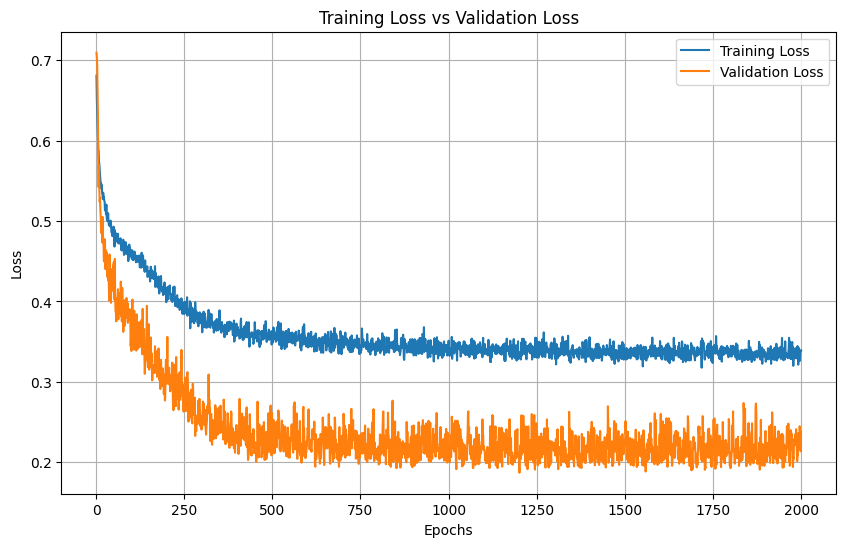

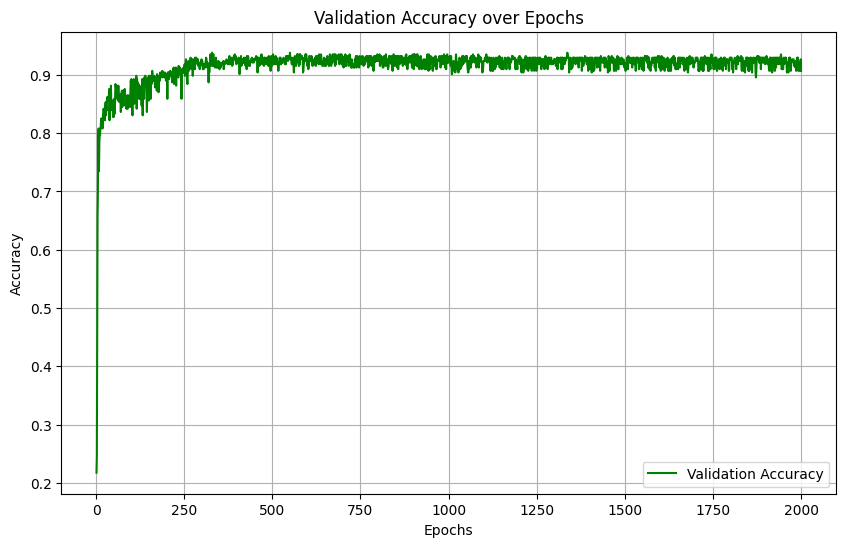

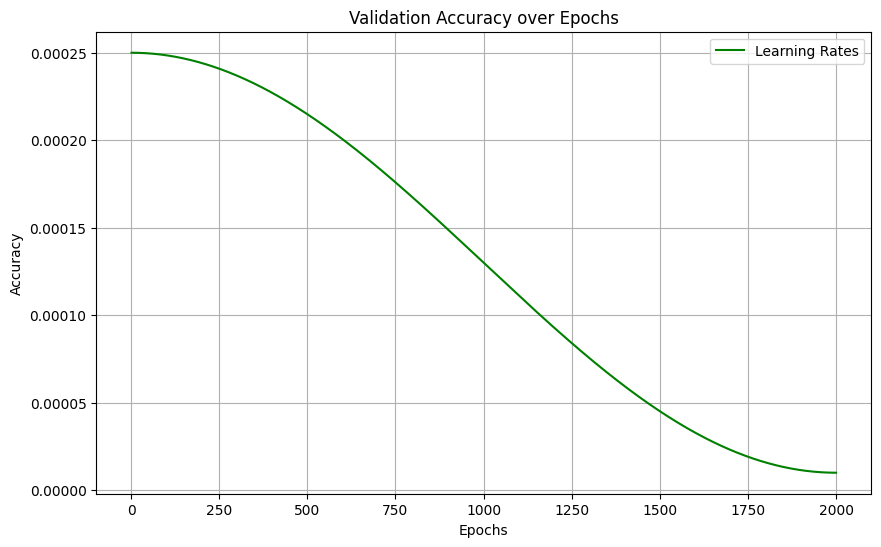

Model for bin 47 saved to GATModels-5A_exp2v2/Models/model_bin_47.pth
Attention weights for bin 47 saved to GATModels-5A_exp2v2/Weights/attn_bin_47.pt
Training on bin 48/50
Bin 48, Epoch 1/2000, Train Loss: 0.8737, Validation Loss: 0.7261,  ValAccuracy: 0.2175, LR: 0.000250
Bin 48, Epoch 501/2000, Train Loss: 0.4195, Validation Loss: 0.3950,  ValAccuracy: 0.8531, LR: 0.000215
Bin 48, Epoch 1001/2000, Train Loss: 0.3726, Validation Loss: 0.3561,  ValAccuracy: 0.9068, LR: 0.000130
Bin 48, Epoch 1501/2000, Train Loss: 0.3685, Validation Loss: 0.3546,  ValAccuracy: 0.9124, LR: 0.000045


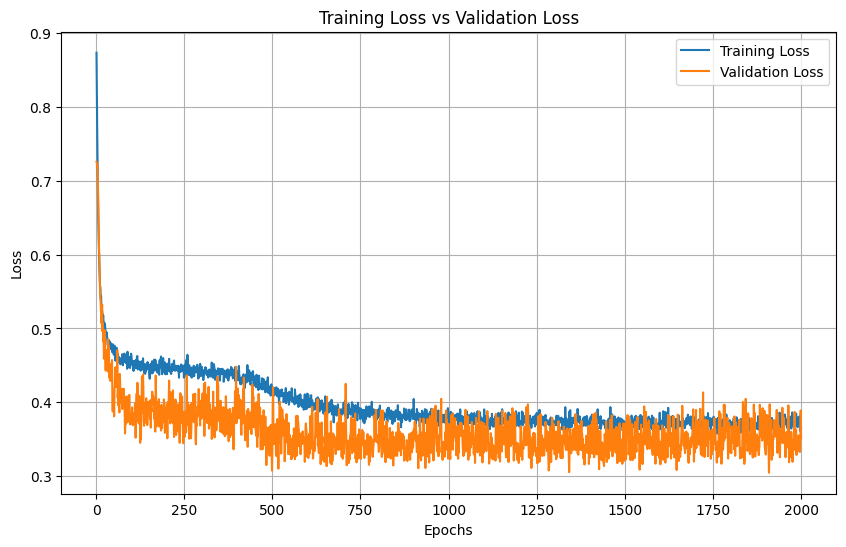

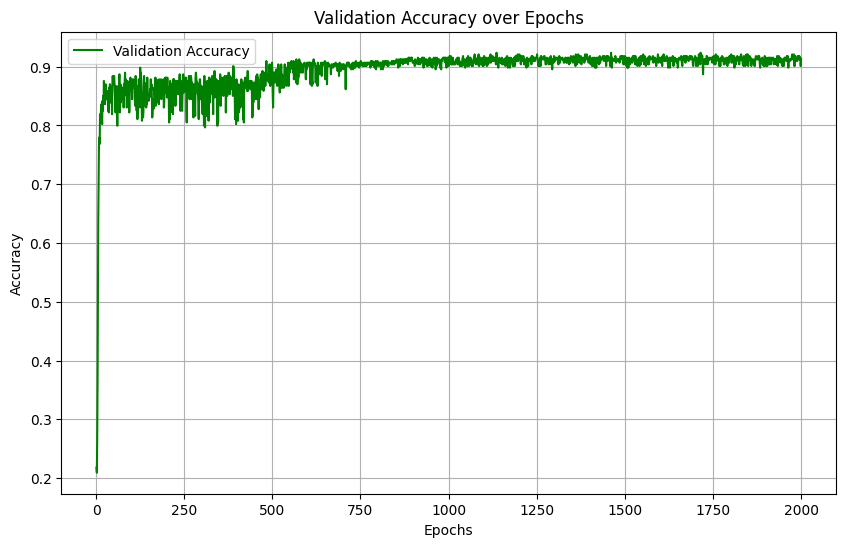

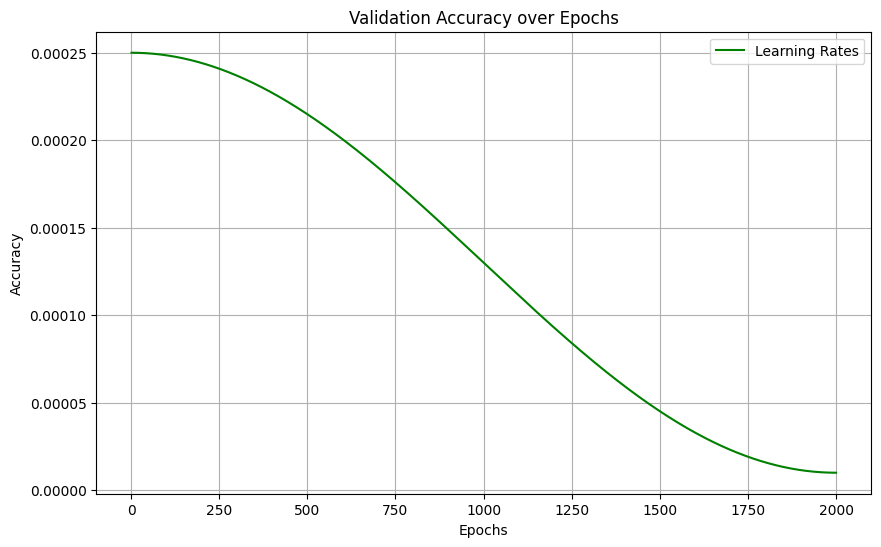

Model for bin 48 saved to GATModels-5A_exp2v2/Models/model_bin_48.pth
Attention weights for bin 48 saved to GATModels-5A_exp2v2/Weights/attn_bin_48.pt
Training on bin 49/50
Bin 49, Epoch 1/2000, Train Loss: 0.7663, Validation Loss: 0.7285,  ValAccuracy: 0.2175, LR: 0.000250
Bin 49, Epoch 501/2000, Train Loss: 0.4064, Validation Loss: 0.2913,  ValAccuracy: 0.9124, LR: 0.000215
Bin 49, Epoch 1001/2000, Train Loss: 0.3991, Validation Loss: 0.2885,  ValAccuracy: 0.9181, LR: 0.000130
Bin 49, Epoch 1501/2000, Train Loss: 0.3975, Validation Loss: 0.3058,  ValAccuracy: 0.9153, LR: 0.000045


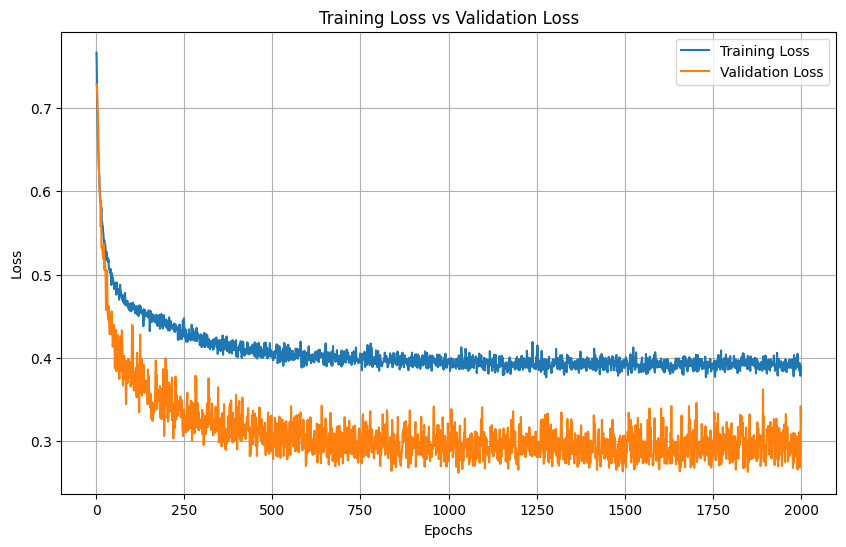

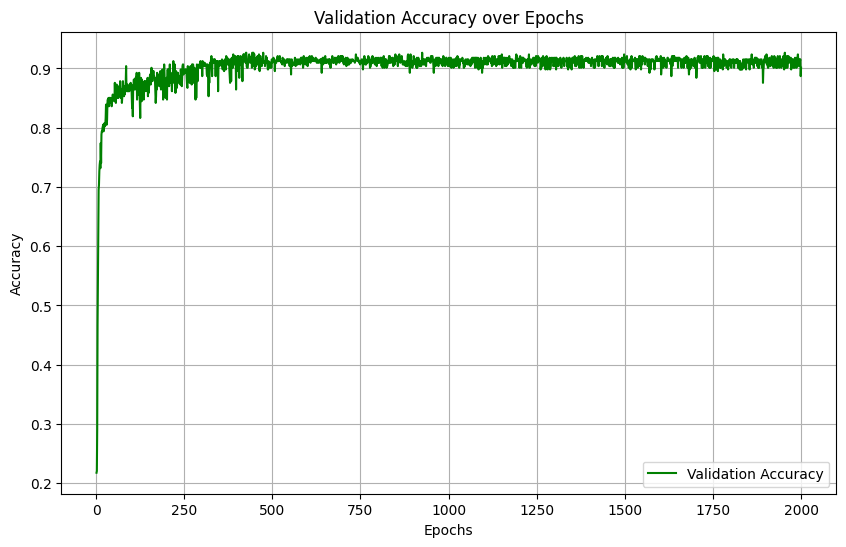

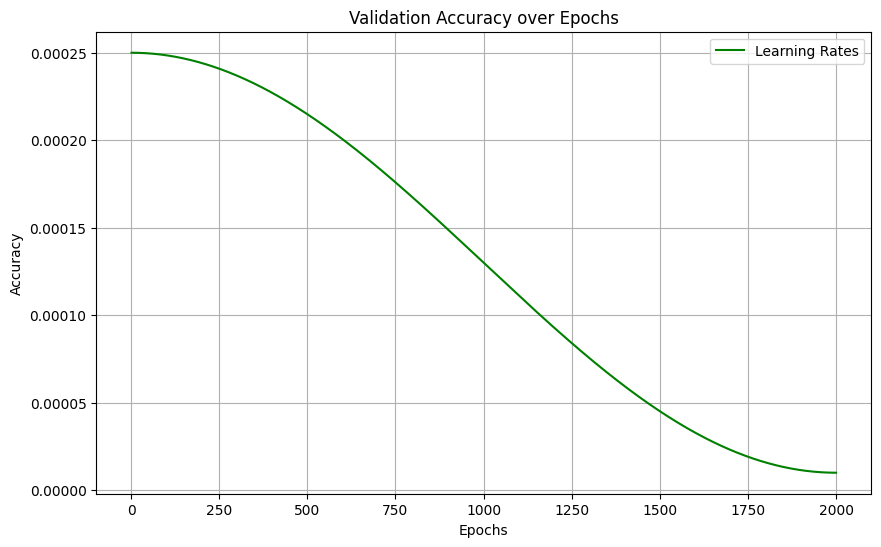

Model for bin 49 saved to GATModels-5A_exp2v2/Models/model_bin_49.pth
Attention weights for bin 49 saved to GATModels-5A_exp2v2/Weights/attn_bin_49.pt
Training on bin 50/50
Bin 50, Epoch 1/2000, Train Loss: 0.8368, Validation Loss: 0.6730,  ValAccuracy: 0.7825, LR: 0.000250
Bin 50, Epoch 501/2000, Train Loss: 0.3798, Validation Loss: 0.2999,  ValAccuracy: 0.9153, LR: 0.000215
Bin 50, Epoch 1001/2000, Train Loss: 0.3694, Validation Loss: 0.3058,  ValAccuracy: 0.9181, LR: 0.000130
Bin 50, Epoch 1501/2000, Train Loss: 0.3608, Validation Loss: 0.3015,  ValAccuracy: 0.9181, LR: 0.000045


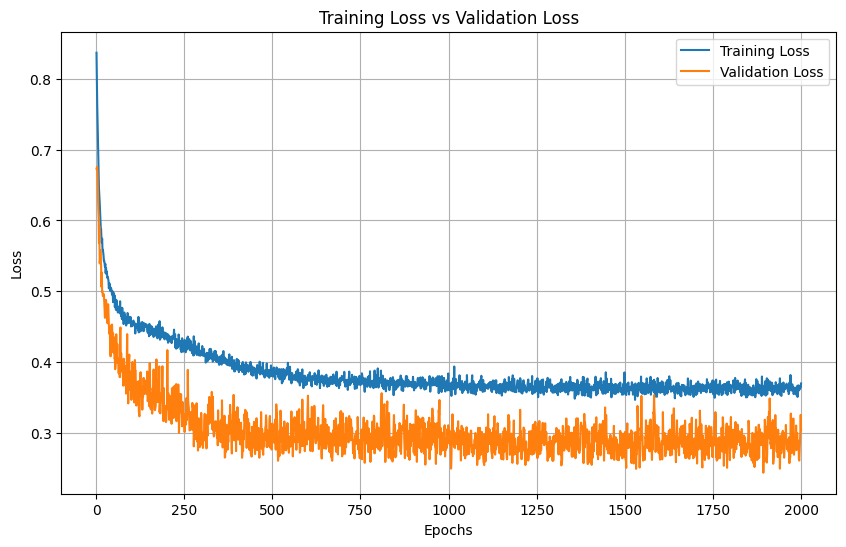

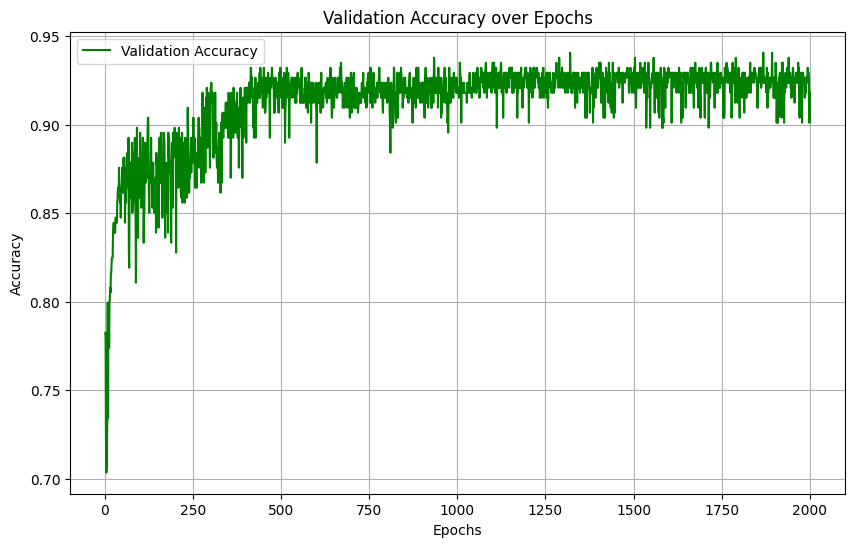

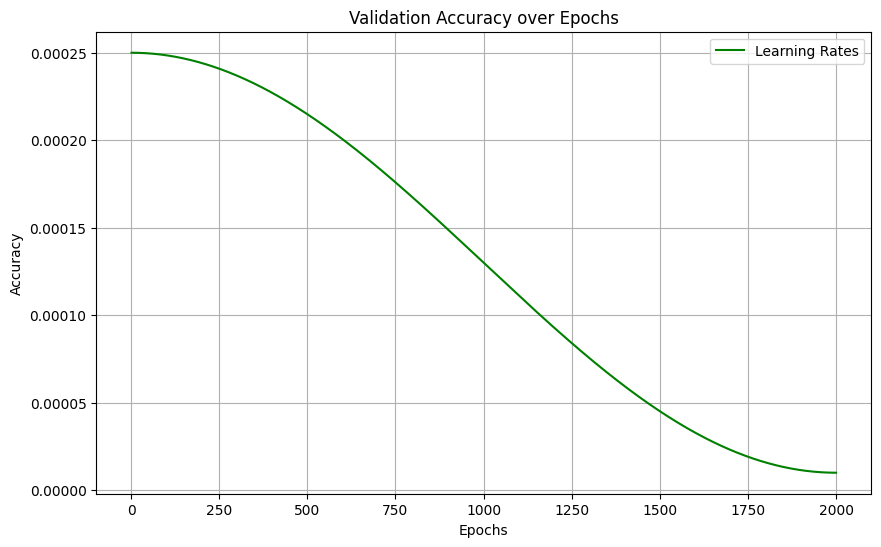

Model for bin 50 saved to GATModels-5A_exp2v2/Models/model_bin_50.pth
Attention weights for bin 50 saved to GATModels-5A_exp2v2/Weights/attn_bin_50.pt


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths for saving models
save_dir = "GATModels-5A_exp2v2"
os.makedirs(f"{save_dir}/Models", exist_ok=True)
os.makedirs(f"{save_dir}/Weights", exist_ok=True)

epochs = 2000
batch_size = 64

val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i, bin in enumerate(bins[40:50], start=40):
    model = GAT(in_channels=37, out_channels=32).to(device)
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.00025, weight_decay=1e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    train_loader = DataLoader(bin, batch_size=batch_size, shuffle=True)    

    print(f"Training on bin {i+1}/{len(bins)}")

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy, attention_data = validate_model(model, val_loader, criterion, device)
        scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 500 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"ValAccuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )
                
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)

    #Save the trained model
    model_path = os.path.join(save_dir, f"Models/model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

    # Save attention weights
    attn_path = os.path.join(save_dir, f"Weights/attn_bin_{i+1}.pt")
    torch.save(attention_data, attn_path)
    print(f"Attention weights for bin {i+1} saved to {attn_path}")
